### Implementation of GCN/GAT to predict RNA-seq expression from Hi-C data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GCN, GAT
from torch_geometric.utils import to_dense_adj

from hires_dataset import HiRESDataset

## GCN Model

In [2]:
class GraphModel(torch.nn.Module):
    def __init__(self, input_features, hidden_channels, num_layers, mlp_layers, model_type="gcn"):
        super().__init__()
        self.input_features = input_features
        if model_type == "gcn":
            model_type = GCN
        elif model_type == "gat":
            model_type = GAT
        else:
            raise NotImplementedError("Only allowed models are `gcn` and `gat`")

        self.graph_model = model_type(
            in_channels=input_features,
            hidden_channels=hidden_channels,
            num_layers=num_layers
        ).type(torch.float32)

        self.mlp = nn.ModuleList()
        for i, size in enumerate(mlp_layers[:-1]):
            self.mlp.append(nn.LazyLinear(size))
            self.mlp.append(nn.ReLU())
            self.mlp.append(nn.Dropout(0.2))
        self.mlp.append(torch.nn.LazyLinear(mlp_layers[-1]))

    def forward(self, batch):
        x = batch.x.float()
        if len(x.shape) < 2:
            x = x.reshape(-1, 1)
        x = self.graph_model(x, batch.edge_index, batch.edge_attr.float())
        x = x.reshape(batch.batch_size, -1)  # B*IC x HC -> B x (ICxHC)

        for layer in self.mlp:
            x = layer(x)
        return x

In [3]:
def forward_pass(model, batch, criterion, mask, device):
    # forward pass
    out = model(batch.to(device))

    # prepare labels
    labels = batch.y.reshape(batch.batch_size, -1).type(torch.float32)
    labels = torch.masked_select(labels, gene_mask.to(device)).reshape(-1, out.shape[1])
    labels = (labels + 1).log()

    # compute loss
    return criterion(out, labels)


def train(model, dataloader, optimizer, criterion, mask, device):
    total_loss = 0
    
    model.train()
    for i, batch in enumerate(tqdm(dataloader)):    
        # compute loss
        loss = forward_pass(model, batch, criterion, mask, device)    
        
        # compute gradients and update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss

    return total_loss.item() / len(dataloader)

def test(model, dataloader, criterion, mask, device):
    total_loss = 0

    model.eval()
    for i, batch in enumerate(tqdm(dataloader)):
        loss = forward_pass(model, batch, criterion, mask, device)
        total_loss += loss

    return total_loss.item() / len(dataloader)

## Load Data

In [6]:
CHR = 17
RESOLUTION = "1Mb"
data = HiRESDataset(
    root="/nfs/turbo/dcmb-class/bioinf593/groups/group_08/datasets/embryos/",
    raw_filename=f"embryos_dataset_{RESOLUTION}_chr{CHR}_observed_time-all_.pt",  #"embryos_dataset_1Mb_['chr6', 'chr11', 'chr17']_observed_time-all_stringdb-100.pt",  #
    processed_filename=f"embryos_dataset_{RESOLUTION}_chr{CHR}_observed_time-all_processed.pt"  # "embryos_combined_100_processed.pt"
)  

In [15]:
train_split = 0.8
split_idx = int(train_split * len(data))
train_data, val_data = data[:split_idx], data[split_idx:]

BATCH_SIZE = 4
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, drop_last=True)

### Construct gene mask

In [17]:
# get top NUM_GENES expressed genes
NUM_GENES = len(data[0].y)

if CHR == 3:
    mask = torch.tensor([1908,  184, 2407,  217, 2312, 1875, 1920, 2098, 2391, 1992])  # hardcode for chr3
elif CHR == 6:
    mask = torch.tensor([1669,  445,  480, 2049,  371, 1635, 2232,  307, 2191, 1878])  # hardcode for chr6
elif CHR == 17:
    mask = torch.tensor([ 323,  765,  120, 1975,  137, 1729, 1588,  167,  333,  367])  # hardcode for chr17
else:
    avg_exp = torch.zeros(len(data[0].y))
    for sample in data:
        avg_exp += sample.y
    avg_exp = avg_exp / len(data)
    mask = avg_exp.argsort(descending=True)[0:NUM_GENES]
# mask = None
print(mask)

gene_mask = torch.zeros((1, len(data[0].y)), dtype=bool)
gene_mask[0, mask] = True

tensor([ 323,  765,  120, 1975,  137, 1729, 1588,  167,  333,  367])


## Instantiate model and optimizer/criterion

In [18]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

HIDDEN_DIM = 32
NUM_LAYERS = 5

MLP_HIDDEN_DIMS = [1024, 512, 128, NUM_GENES]
MODEL_TYPE = "gcn"

model = GraphModel(1, HIDDEN_DIM, NUM_LAYERS, MLP_HIDDEN_DIMS, MODEL_TYPE)
model = model.to(device)
print(model)
print(device)

GraphModel(
  (graph_model): GCN(1, 32, num_layers=5)
  (mlp): ModuleList(
    (0): LazyLinear(in_features=0, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LazyLinear(in_features=0, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): LazyLinear(in_features=0, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): LazyLinear(in_features=0, out_features=2142, bias=True)
  )
)
cuda:0


/home/aakashdp/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
LR = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

# Train Model

In [ ]:
print(f"Training on {device}")
train_loss = []
val_loss = []

# print("Evaluating baseline")
# train_loss.append(test(model, train_dataloader, criterion, gene_mask, device))
# val_loss.append(test(model, val_dataloader, criterion, gene_mask, device))
print("Training...")

NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    train_loss.append(train(model, train_dataloader, optimizer, criterion, gene_mask, device))
    vloss = test(model, val_dataloader, criterion, gene_mask, device)
    val_loss.append(vloss)
    print(f"Epoch {epoch+1}\tTrain Loss = {train_loss[-1]:.6f} Val Loss = {val_loss[-1]:.6f}")

In [10]:
SAVE_PATH = f"models/combined_{MODEL_TYPE}_epoch_{epoch+1}_loss_{vloss:.4f}.pt"
torch.save(model.state_dict(), SAVE_PATH)

# Plot Results

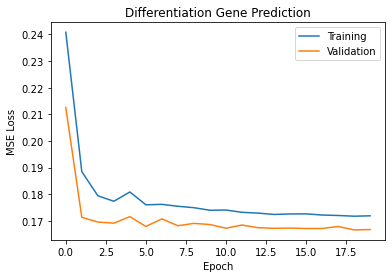

In [11]:
plt.figure(figsize=(6, 4))
plt.title(f"Differentiation Gene Prediction")
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
# plt.savefig(f"figures/training_figures/combined_diff_gene_{MODEL_TYPE}.png")

In [12]:
torch.save({"train_loss": train_loss, "val_loss": val_loss}, f"figures/training_losses/combined_diff_gene_{MODEL_TYPE}_losses.pt")

# Predict on sample

In [47]:
test_dataloader = DataLoader([data[6008], data[6001], data[6002]], batch_size=1, shuffle=False)

In [42]:
model = model.to(device)
model.eval();

In [61]:
preds = []
for batch in test_dataloader:
    pred = model(batch.to(device))
    preds.append((pred.exp() - 1).detach().cpu())

In [62]:
torch.save(preds, "recon_rnaseq.pt")

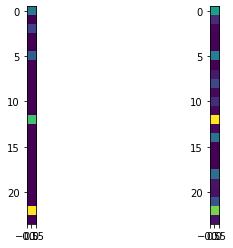

In [63]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data[6001].y.reshape(-1, 1))
ax[1].imshow(preds[1].detach().cpu().reshape(-1, 1))